# Fine-tuning for classification
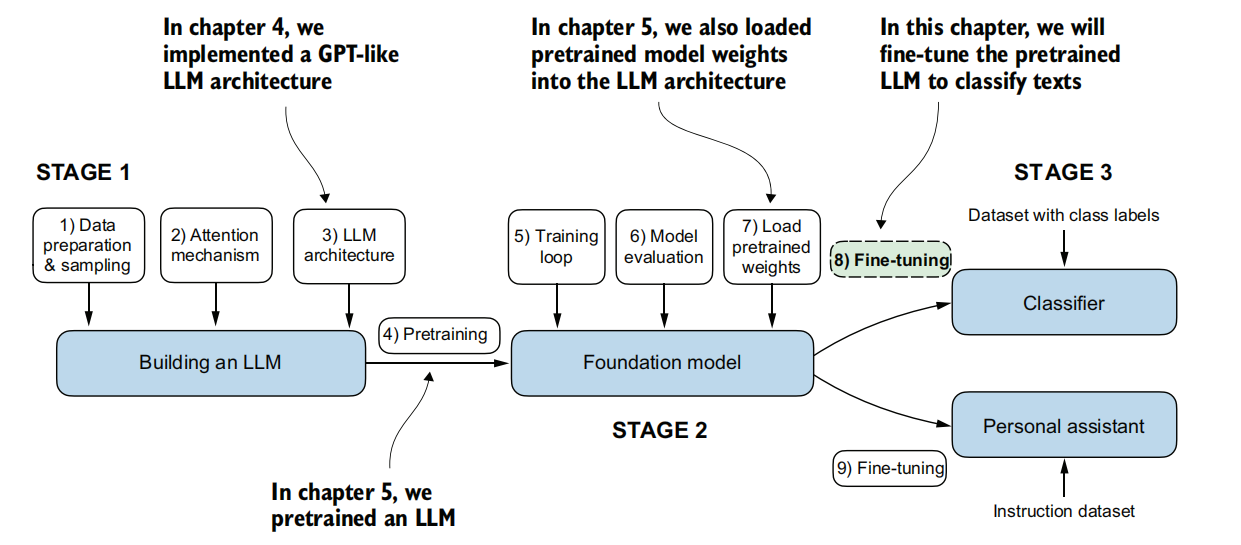

## 1. Instruction Fine-Tuning
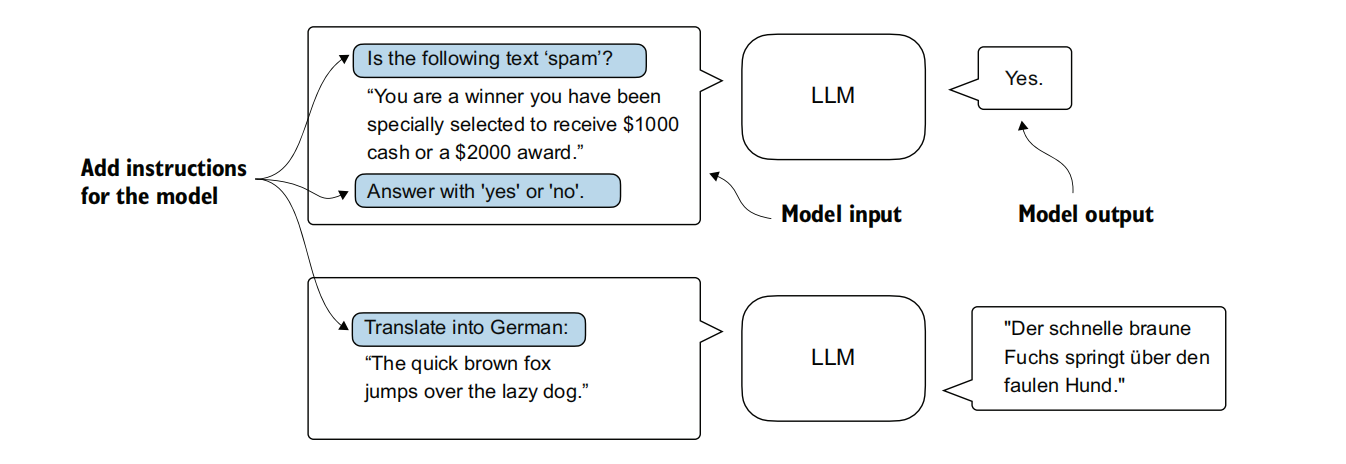

## 2. Classification Fine-Tuning
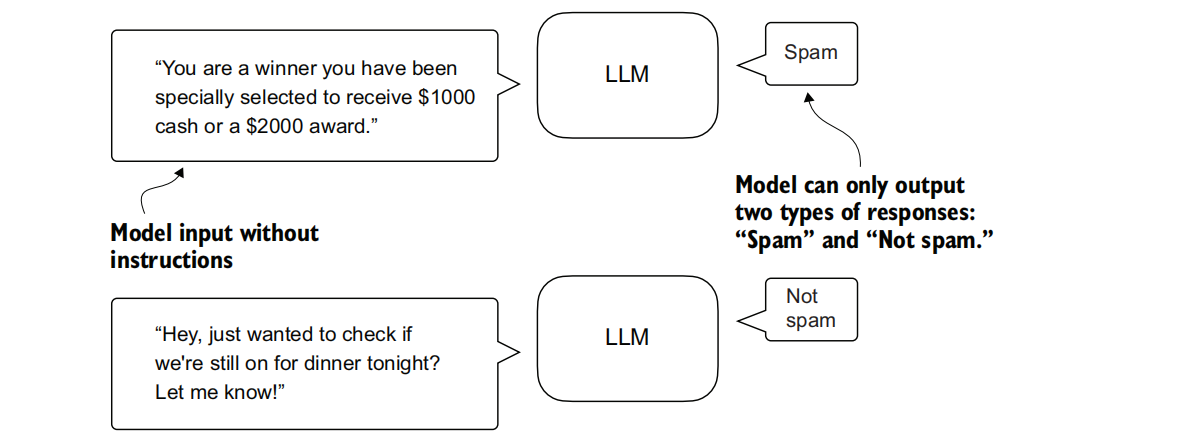

## Preparing the dataset

In [1]:
import urllib.request
import zipfile
import os
from pathlib import Path

In [2]:
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download ""and extraction.")
        return
    with urllib.request.urlopen(url) as response: 
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())
    with zipfile.ZipFile(zip_path, "r") as zip_ref: 
        zip_ref.extractall(extracted_path)
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path) 
    print(f"File downloaded and saved as {data_file_path}")
download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection\SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [3]:
import pandas as pd
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

c:\Users\AKSHAT SHAW\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


#### Creating a Balanced data-set

In [5]:
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0] 
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123) 
    balanced_df = pd.concat([
        ham_subset, df[df["Label"] == "spam"]
    ]) 
    return balanced_df
balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [6]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [7]:
def random_split(df, train_frac, validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True) 
    
    train_end = int(len(df) * train_frac) 
    validation_end = train_end + int(len(df) * validation_frac)
    
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]
    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

In [8]:
# train_df.to_csv("train.csv", index=None)
# validation_df.to_csv("validation.csv", index=None)
# test_df.to_csv("test.csv", index=None)

## Creating the DataLoaders

We now have 2 options for the data:
1. Truncate all messages to the length of the shortest message in the dataset or batch.
2. Pad all messages to the length of the longest message in the dataset or batch.

The first option is computationally cheaper, but it may result in significant information loss if shorter messages are much smaller than the average or longest messages,potentially reducing model performance.

So we will go on with the 2nd option.

- To implement batching, where all messages are padded to the length of the longest message in the dataset, we add padding tokens to all shorter messages. For this
purpose, we use "<|endoftext|>" as a padding token.

In [9]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


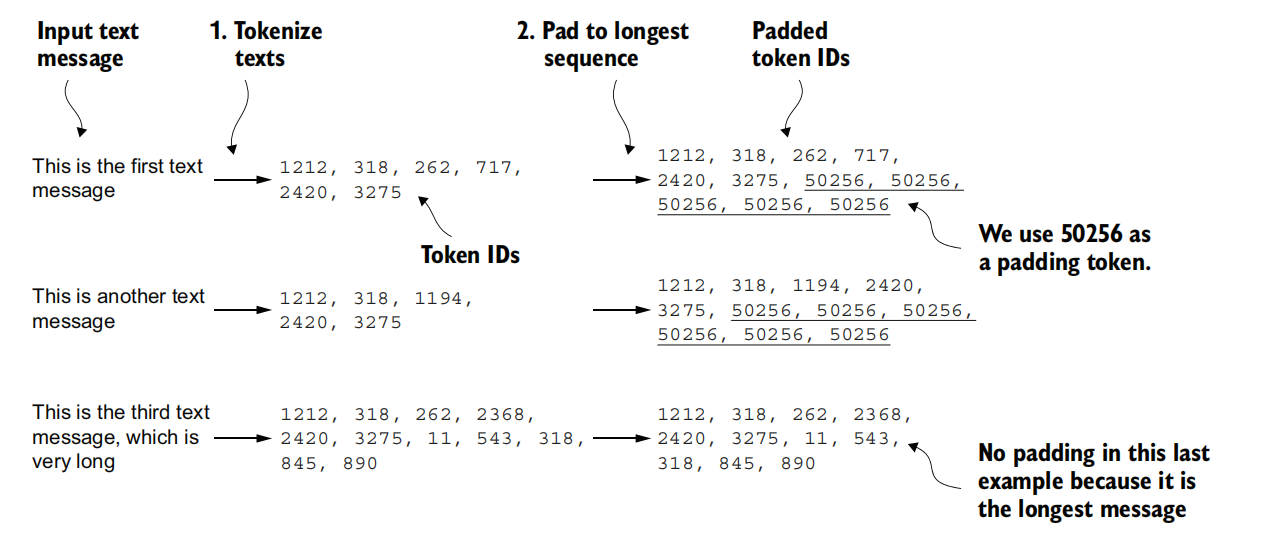

In [10]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [tokenizer.encode(text) for text in self.data["Text"]]
        
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
        
        self.encoded_texts = [
            encoded_text[:self.max_length] for encoded_text in self.encoded_texts
        ]
        
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]
    
    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )
    
    def __len__(self):
        return len(self.data)
    
    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length


#### We trim the samples longer than max_length in the test/val data and pad samples of lesser length 

In [11]:
train_dataset = SpamDataset(
 csv_file="train.csv",
 max_length=None,
 tokenizer=tokenizer
)

In [12]:
print(train_dataset.max_length)

120


In [13]:
val_dataset = SpamDataset(
 csv_file="validation.csv",
 max_length=train_dataset.max_length,
 tokenizer=tokenizer
)
test_dataset = SpamDataset(
 csv_file="test.csv",
 max_length=train_dataset.max_length,
 tokenizer=tokenizer
)

In [14]:
from torch.utils.data import DataLoader

num_workers = 0 
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [15]:
for input_batch, target_batch in train_loader:
    print("Input batch dimensions:", input_batch.shape)
    print("Label batch dimensions", target_batch.shape)
    break

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [16]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


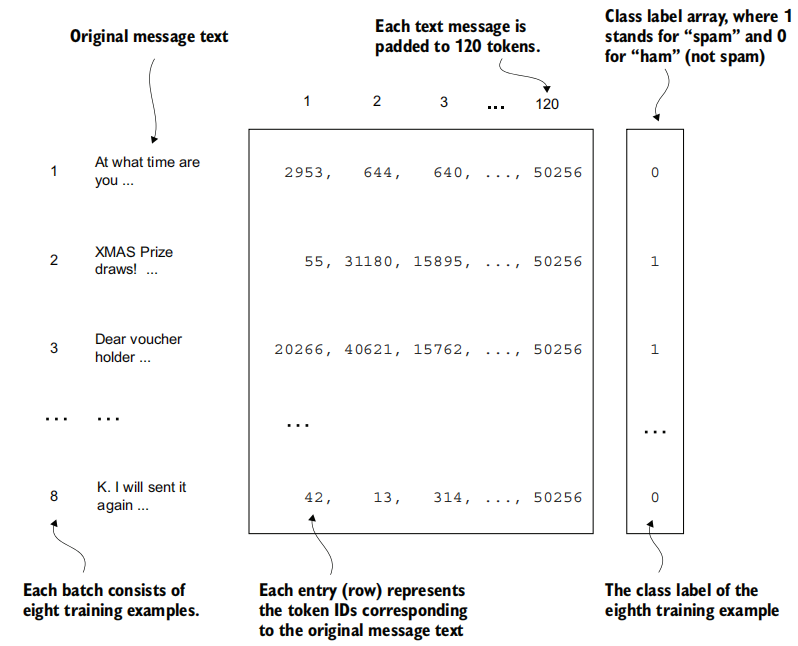

## Initializing a model with pretrained weights

In [17]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
 "vocab_size": 50257, 
 "context_length": 1024, 
 "drop_rate": 0.0, 
 "qkv_bias": True 
}
model_configs = {
 "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
 "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
 "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
 "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

GPT_CONFIG_124M = {
 "vocab_size": 50257,
 "context_length": 256, # We shorten the context length from 1,024 to 256 tokens. Original GPT-2 has a context length of 1,024 tokens.
 "emb_dim": 768,
 "n_heads": 12,
 "n_layers": 12, 
 "drop_rate": 0.1, 
 "qkv_bias": False
}

In [22]:
from gpt_download import download_and_load_gpt2, load_weights_into_gpt
from gpt import GPTModel
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings, params = download_and_load_gpt2(                
        model_size=model_size, models_dir="gpt2"
)


File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001


In [23]:
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

### Trying our own model v1.1 instead of the original model

In [19]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# from gpt import GPTModel

# checkpoint = torch.load("../ch 5/akGPT-1.1.pth", map_location=device)
# model = GPTModel(GPT_CONFIG_124M)
# model.load_state_dict(checkpoint["model_state_dict"])
# optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
# optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# model.eval()

C:\Users\AKSHAT SHAW\AppData\Local\Temp\ipykernel_17740\2236289044.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("../ch 5/akGPT-1.1.pth", map_l

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

: 

Testing the loaded model

In [24]:
from gpt import generate_text_simple
from utils import text_to_token_ids, token_ids_to_text
text_1 = "Every effort moves you"
token_ids = generate_text_simple(
 model=model,
 idx=text_to_token_ids(text_1, tokenizer),
 max_new_tokens=25,
 context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work.

The second step is to understand the


- Before we start fine-tuning the model as a spam classifier, let’s see whether the model
already classifies spam messages by prompting it with instructions:

In [25]:
text_2 = (
 "Is the following text 'spam'? Answer with 'yes' or 'no':"
 " 'You are a winner you have been specially"
 " selected to receive $1000 cash or a $2000 award.'"
)
token_ids = generate_text_simple(
 model=model,
 idx=text_to_token_ids(text_2, tokenizer),
 max_new_tokens=23,
 context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


## Adding a classification head

- We must modify the pretrained LLM to prepare it for classification fine-tuning. To do
so, we replace the original output layer, which maps the hidden representation to a
vocabulary of 50,257, with a smaller output layer that maps to two classes: 0 & 1

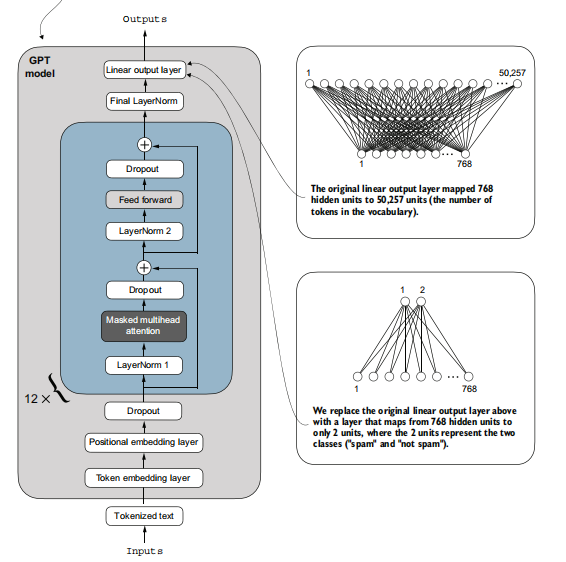

- Next, we replace the out_head with a new output layer that we will
fine-tune.

In [26]:
for param in model.parameters():
    param.requires_grad = False

### Fine-tuning selected layers vs. all layers
- Since we start with a pretrained model, it’s not necessary to fine-tune all model layers.
- In neural network-based language models, the lower layers generally capture basic language structures and semantics applicable across a wide range of tasks and datasets.
- So, fine-tuning only the last layers (layers near the output), which are more specific
to nuanced linguistic patterns and task-specific features, is often sufficient to adapt the
model to new tasks.
- A nice side effect is that it is computationally more efficient to finetune only a small number of layers.

### Adding a classification layer

In [27]:
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
 in_features=BASE_CONFIG["emb_dim"], 
 out_features=num_classes
)

- This new model.out_head output layer has its requires_grad attribute set to
True by default, which means that it’s the only layer in the model that will be
updated during training.

In [28]:
# For training the final layer norm and last transformer block trainable

for param in model.trf_blocks[-1].parameters():
 param.requires_grad = True
for param in model.final_norm.parameters():
 param.requires_grad = True

### We can still use this model similarly to how we have previously

In [29]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [30]:
with torch.no_grad():
 outputs = model(inputs)
print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


### For the fine-tuning we will focus on the last row corresponding to the last output token

In [31]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


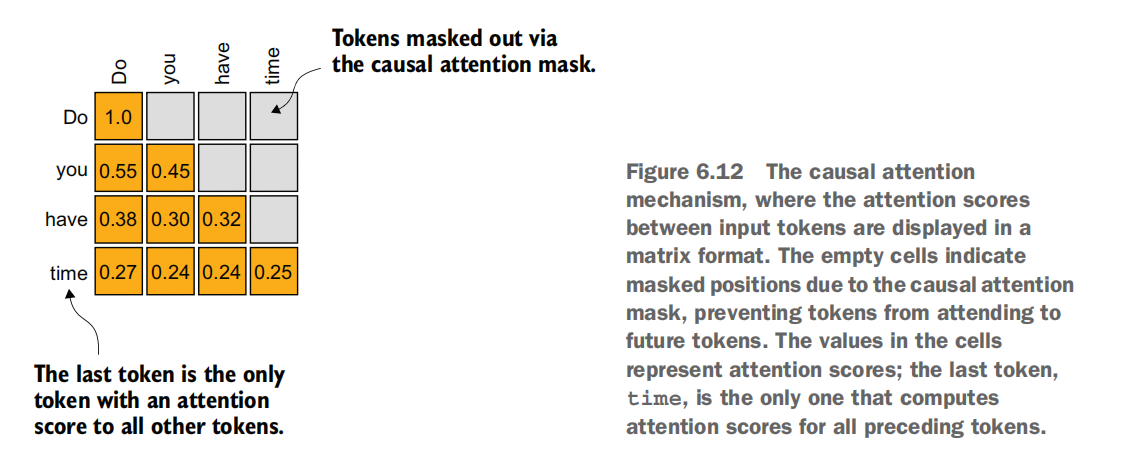

- Given the causal attention mask setup in figure 6.12, the last token in a sequence accumulates the most information since it is the only token with access to data from all the
previous tokens. 
Therefore, in our spam classification task, we focus on this last token
during the fine-tuning process.

## Calculating the classification loss and accuracy

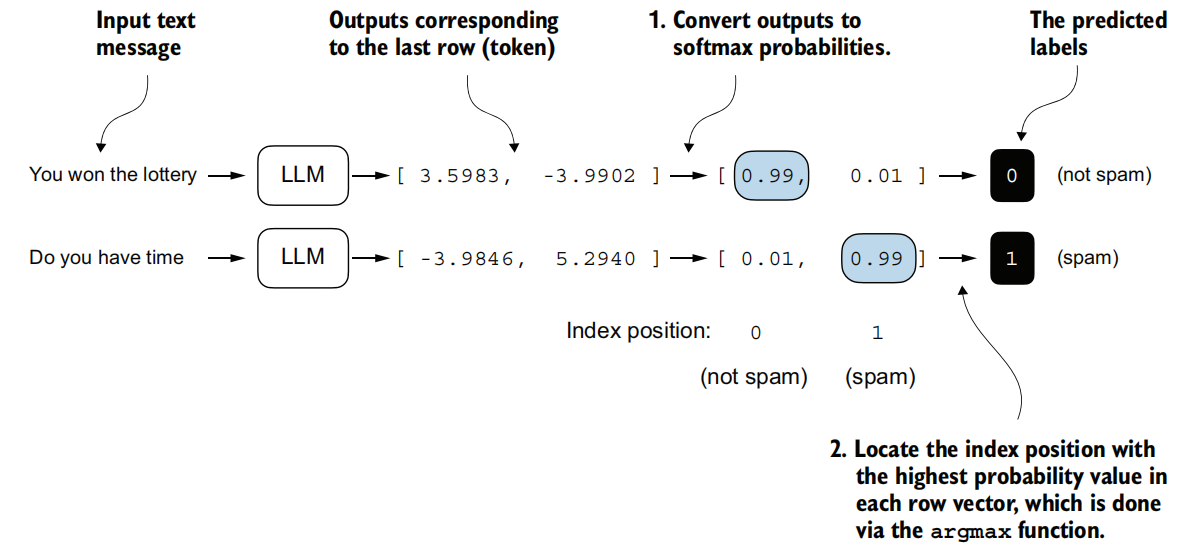

In [32]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


In [33]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


#### Calculating the classification accuracy

In [34]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]          # logits for the last token
                predicted_labels = torch.argmax(logits, dim=-1)
                num_examples += predicted_labels.shape[0]
                correct_predictions += ((predicted_labels == target_batch).sum().item())
        else:
            break
    return correct_predictions / num_examples

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
 train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
 val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
 test_loader, model, device, num_batches=10
)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


### Calculating the cross-entropy loss

In [36]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [37]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else: 
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
            input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

- Intial loss

In [38]:
with torch.no_grad(): 
    train_loss = calc_loss_loader(
    train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)
print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


# Fine-tuning the model on supervised data

In [43]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: akshatshaw47 (akshatshaw47-iit-roorkee). Use `wandb login --relogin` to force relogin


True

In [40]:
def train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs, eval_freq, eval_iter, project_name="gpt2-finetune-classification", run_name=None):
    # Initialize wandb
    wandb.init(project=project_name, name=run_name)
    
    # Log hyperparameters
    wandb.config.update({
        "epochs": num_epochs,
        "eval_frequency": eval_freq,
        "eval_iterations": eval_iter,
        "optimizer": optimizer.__class__.__name__,
        "learning_rate": optimizer.param_groups[0]['lr'],
        "device": device,
        "model_name": model.__class__.__name__
    })
    
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        batch_count = 0
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()
            optimizer.step()
            
            # Track batch-level metrics
            epoch_loss += loss.item()
            batch_count += 1
            examples_seen += input_batch.shape[0]
            global_step += 1
            
            # Log batch metrics
            wandb.log({
                "batch_loss": loss.item(),
                "examples_seen": examples_seen,
                "global_step": global_step
            }, step=global_step)
            
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                
                # Log evaluation metrics
                wandb.log({
                    "train_loss": train_loss,
                    "val_loss": val_loss,
                    "epoch": epoch + 1
                }, step=global_step)
                
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}")
        
        # Calculate and log accuracies at epoch end
        train_accuracy = calc_accuracy_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_accuracy = calc_accuracy_loader(
            val_loader, model, device, num_batches=eval_iter
        )
        
        # Log epoch-level metrics
        wandb.log({
            "epoch": epoch + 1,
            "epoch_avg_loss": epoch_loss / batch_count,
            "train_accuracy": train_accuracy * 100,
            "val_accuracy": val_accuracy * 100,
            "learning_rate": optimizer.param_groups[0]['lr']  # Track if LR changes
        }, step=global_step)
        
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
    
    # Close wandb run
    wandb.finish()
    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [41]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
        val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

In [44]:
import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
losses_t, losses_v, acc_t, acc_v, examples = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=10, eval_freq=100, eval_iter=10,
    project_name="gpt2-finetune-classification", run_name="spam/ham"
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.559, Val loss 2.626
Ep 1 (Step 000100): Train loss 0.547, Val loss 0.570
Training accuracy: 70.00% | Validation accuracy: 77.50%
Ep 2 (Step 000200): Train loss 0.403, Val loss 0.383
Training accuracy: 82.50% | Validation accuracy: 81.25%
Ep 3 (Step 000300): Train loss 0.384, Val loss 0.380
Training accuracy: 90.00% | Validation accuracy: 86.25%
Ep 4 (Step 000400): Train loss 0.171, Val loss 0.206
Ep 4 (Step 000500): Train loss 0.158, Val loss 0.075
Training accuracy: 96.25% | Validation accuracy: 98.75%
Ep 5 (Step 000600): Train loss 0.069, Val loss 0.059
Training accuracy: 97.50% | Validation accuracy: 98.75%
Ep 6 (Step 000700): Train loss 0.134, Val loss 0.038
Training accuracy: 98.75% | Validation accuracy: 98.75%
Ep 7 (Step 000800): Train loss 0.046, Val loss 0.041
Ep 7 (Step 000900): Train loss 0.087, Val loss 0.104
Training accuracy: 98.75% | Validation accuracy: 97.50%
Ep 8 (Step 001000): Train loss 0.044, Val loss 0.027
Training accuracy: 98.75%

batch_loss,▇▆▇▆▅▄▅▃█▄▂▂▆▃▂▂▂▁▁▆▁▁▂▂▂▁▄▁▁▁▁▁▁▇▁▁▁▁▁▁
epoch,▁▁▁▂▂▃▃▃▃▃▄▄▅▅▆▆▆▆▆▇▇██
epoch_avg_loss,█▅▄▃▂▂▁▁▁▁
examples_seen,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇██
global_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▆▇▇█████
train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▄███████
val_loss,█▂▂▂▁▁▁▁▁▁▁▁▁
batch_loss,0.00063


Training completed in 3.98 minutes.


In [39]:
# import matplotlib.pyplot as plt
# def plot_values(epochs_seen, examples_seen, train_values, val_values,label="loss"):
#     fig, ax1 = plt.subplots(figsize=(5, 3))
    
#     ax1.plot(epochs_seen, train_values, label=f"Training {label}")
#     ax1.plot(
#     epochs_seen, val_values, linestyle="-.",
#     label=f"Validation {label}"
#     )
#     ax1.set_xlabel("Epochs")
#     ax1.set_ylabel(label.capitalize())
#     ax1.legend()
    
#     ax2 = ax1.twiny()
#     ax2.plot(examples_seen, train_values, alpha=0) 
#     ax2.set_xlabel("Examples seen")
#     fig.tight_layout() 
#     plt.savefig(f"{label}-plot.pdf")
#     plt.show()

# epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
# examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
# plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

# epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
# examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
# plot_values(
#  epochs_tensor, examples_seen_tensor, train_accs, val_accs,
#  label="accuracy"
# )

In [45]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 99.04%
Validation accuracy: 97.32%
Test accuracy: 96.00%


# Using the LLM as a spam classifier

In [46]:
def classify_review(text, model, tokenizer, device, max_length=None,pad_token_id=50256):
    model.eval()
    input_ids = tokenizer.encode(text) 
    supported_context_length = model.pos_emb.weight.shape[1]
    input_ids = input_ids[:min( 
          max_length, supported_context_length      # truncate if needed
        )]
    input_ids += [pad_token_id] * (max_length - len(input_ids))     # pad if needed
    
    input_tensor = torch.tensor(
    input_ids, device=device
    ).unsqueeze(0) 
    
    with torch.no_grad(): 
        logits = model(input_tensor)[:, -1, :] 
        predicted_label = torch.argmax(logits, dim=-1).item()
    return "spam" if predicted_label == 1 else "not spam"

In [47]:
text_1 = (
 "You are a winner you have been specially selected to receive $1000 cash or a $2000 award."
)
print(classify_review(
 text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

text_2 = (
 "Hey, just wanted to check if we're still on for dinner tonight? Let me know!"
)
print(classify_review(
 text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

spam
not spam


### Let's save this fine-tuned model

In [48]:
torch.save(model.state_dict(), "akGPT-v1.1-fintuned-v1.1.pth")

In [ ]:
model_state_dict = torch.load("akGPT-v1.1-fintuned-v1.1.pth", map_location=device)
model.load_state_dict(model_state_dict)

# End of Notebook